In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [125]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [126]:
N = 1000
delta_t = 0.3
rho = 0.9
print("N: ",N,"delta t: ",delta_t,"rho: ",rho)

x1,x2 = correlated_ts(c_rho(rho),delta_t=delta_t,N=N)
print("Pearson r,p: ",pearsonr(x1,x2))
print(x1.std()**2,x2.std()**2)

N:  1000 delta t:  0.3 rho:  0.9
Pearson r,p:  (0.8957600102662966, 0.0)
0.25317334179884976 0.256331841726595


In [127]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [128]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (N/2/A**2 - 
            q(aep,ass,ac,b)/A**3 +
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
           1/A*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

In [129]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [130]:
para = calc_fundstats(x1+x2) + calc_fundstats(x1-x2) +(delta_t,N)
para

(8.92655548678968,
 958.9589658894324,
 713.8955818054535,
 0.04225158518240828,
 53.10565650664669,
 -1.5341360164822921,
 0.3,
 1000)

In [131]:
guessa1 = (x1+x2).std()**2
guessa2 = (x1-x2).std()**2
guessd = 0.5
c_guess = (guessa1-guessa2)/guessa2
print(guessa1,guessa2,guessd,c_guess/(2+c_guess))
result = root(phi_deriv, [guessa1,guessa2,guessd],args=para)
print(result.x)
#print(phi_deriv(result.x,*para))
#print(phi_deriv([guessa1,guessa2,guessd],*para))
A1 = result.x[0]
A2 = result.x[1]
D = result.x[2]

0.96589078236712 0.05311958468376935 0.5 0.8957427983043934
[0.97664108 0.05308104 0.9659057 ]


In [132]:
c_max = (result.x[0]-result.x[1])/result.x[1]
rho_max = c_max/(2+c_max)
print(c_max,rho_max)

17.399055381570186 0.8969021964904501


In [133]:
# lets calculate the Jacobian
b1 = b(D,A1,delta_t)
b2 = b(D,A2,delta_t)
a1ep,a1ss,a1c = calc_fundstats(x1+x2)
a2ep,a2ss,a2c = calc_fundstats(x1-x2)
d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)

In [134]:
hessian = np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])
hessian

array([[-8.10235560e+02,  0.00000000e+00,  6.58973173e+02],
       [ 0.00000000e+00, -1.79114530e+05,  6.09320432e+01],
       [ 6.58973173e+02,  6.09320432e+01, -1.06190550e+03]])

In [135]:
var = -np.linalg.inv(hessian)
var

array([[2.49192003e-03, 5.26064951e-07, 1.54640927e-03],
       [5.26064951e-07, 5.58324002e-06, 6.46819246e-07],
       [1.54640927e-03, 6.46819246e-07, 1.90137601e-03]])

In [136]:
print(np.sqrt(var[0,0]))
print(np.sqrt(var[1,1]))
print(np.sqrt(var[2,2]))

0.049919134930020835
0.0023628880683844613
0.043604770475263864


In [137]:
d2PdA2_1mN = d2PdA2N(N,b1,A1,delta_t)
d2PdA2_2mN = d2PdA2N(N,b2,A2,delta_t)
d2PdD2mN = d2PdD2N(N,b1,b2,D,A1,A2,delta_t)
d2PdAdD_1mN = d2PdAdDN(N,b1,D,A1,delta_t)
d2PdAdD_2mN = d2PdAdDN(N,b2,D,A2,delta_t)

In [138]:
hessian2 = np.array([[d2PdA2_1mN,0,d2PdAdD_1mN],[0,d2PdA2_2mN,d2PdAdD_2mN],[d2PdAdD_1mN,d2PdAdD_2mN,d2PdD2mN]])
hessian2

array([[ -808.30500144,     0.        ,   678.80265543],
       [    0.        , -9612.44723375,    10.70260007],
       [  678.80265543,    10.70260007, -1070.31778291]])

In [139]:
var2 = -np.linalg.inv(hessian2)
var2

array([[2.64690978e-03, 1.86908948e-06, 1.67870647e-03],
       [1.86908948e-06, 1.04034259e-04, 2.22567540e-06],
       [1.67870647e-03, 2.22567540e-06, 1.99897102e-03]])

In [140]:
print(np.sqrt(var2[0,0]))
print(np.sqrt(var2[1,1]))
print(np.sqrt(var2[2,2]))

0.051448127047286255
0.010199718550956338
0.044709853735540844


In [168]:
# lets plot dA1, dA2, dD as function of delta t/tau
delta_t_list = np.linspace(0.001,3,100)
rho = 0.1
c = 2*rho/(1-rho)
N = 100000
A1 = 1.0
A2 = 1.0/(1.0+c)
D = 1.0
dA1_list = []
dA2_list = []
dA1A2_list = []
dA1dD_list = []
dA2dD_list = []
dD_list = []
print("N: ",N,"delta t: ",delta_t,"rho: ",rho)
for dt in delta_t_list:
    b1 = b(D,A1,dt)
    b2 = b(D,A2,dt)
    d2PdA2_1mN = d2PdA2N(N,b1,A1,dt)
    d2PdA2_2mN = d2PdA2N(N,b2,A2,dt)
    d2PdD2mN = d2PdD2N(N,b1,b2,D,A1,A2,dt)
    d2PdAdD_1mN = d2PdAdDN(N,b1,D,A1,dt)
    d2PdAdD_2mN = d2PdAdDN(N,b2,D,A2,dt)
    hessian = np.array([[d2PdA2_1mN,0,d2PdAdD_1mN],[0,d2PdA2_2mN,d2PdAdD_2mN],[d2PdAdD_1mN,d2PdAdD_2mN,d2PdD2mN]])
    var = -np.linalg.inv(hessian)
    dA1_list.append(var[0,0])
    dA2_list.append(var[1,1])
    dD_list.append(var[2,2])
    dA1A2_list.append(var[0,1])
    dA1dD_list.append(var[0,2])
    dA2dD_list.append(var[1,2])
dA1_01 = np.array(dA1_list)
dA2_01 = np.array(dA2_list)
dD_01 = np.array(dD_list)
dA1A2_01 = np.array(dA1A2_list)
dA1dD_01 = np.array(dA1dD_list)
dA2dD_01 = np.array(dA2dD_list)
dC_01 = np.sqrt(1/A2**2*dA1+A1**2/A2**4*dA2-A1/A2**4*dA1A2)
dtau1_01 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
dtau2_01 = np.sqrt(1/D**2*dA2+A2**2/D**4*dD-A2/D**3*dA2dD)

N:  100000 delta t:  0.3 rho:  0.1


In [169]:
# lets plot dA1, dA2, dD as function of delta t/tau
delta_t_list = np.linspace(0.001,3,100)
rho = 0.25
c = 2*rho/(1-rho)
N = 100000
A1 = 1.0
A2 = 1.0/(1.0+c)
D = 1.0
dA1_list = []
dA2_list = []
dA1A2_list = []
dA1dD_list = []
dA2dD_list = []
dD_list = []
print("N: ",N,"delta t: ",delta_t,"rho: ",rho)
for dt in delta_t_list:
    b1 = b(D,A1,dt)
    b2 = b(D,A2,dt)
    d2PdA2_1mN = d2PdA2N(N,b1,A1,dt)
    d2PdA2_2mN = d2PdA2N(N,b2,A2,dt)
    d2PdD2mN = d2PdD2N(N,b1,b2,D,A1,A2,dt)
    d2PdAdD_1mN = d2PdAdDN(N,b1,D,A1,dt)
    d2PdAdD_2mN = d2PdAdDN(N,b2,D,A2,dt)
    hessian = np.array([[d2PdA2_1mN,0,d2PdAdD_1mN],[0,d2PdA2_2mN,d2PdAdD_2mN],[d2PdAdD_1mN,d2PdAdD_2mN,d2PdD2mN]])
    var = -np.linalg.inv(hessian)
    dA1_list.append(var[0,0])
    dA2_list.append(var[1,1])
    dD_list.append(var[2,2])
    dA1A2_list.append(var[0,1])
    dA1dD_list.append(var[0,2])
    dA2dD_list.append(var[1,2])
dA1_025 = np.array(dA1_list)
dA2_025 = np.array(dA2_list)
dD_025 = np.array(dD_list)
dA1A2_025 = np.array(dA1A2_list)
dA1dD_025 = np.array(dA1dD_list)
dA2dD_025 = np.array(dA2dD_list)
dC_025 = np.sqrt(1/A2**2*dA1+A1**2/A2**4*dA2-A1/A2**4*dA1A2)
dtau1_025 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
dtau2_025 = np.sqrt(1/D**2*dA2+A2**2/D**4*dD-A2/D**3*dA2dD)

N:  100000 delta t:  0.3 rho:  0.25


In [170]:
# lets plot dA1, dA2, dD as function of delta t/tau
delta_t_list = np.linspace(0.001,3,100)
rho = 0.5
c = 2*rho/(1-rho)
N = 100000
A1 = 1.0
A2 = 1.0/(1.0+c)
D = 1.0
dA1_list = []
dA2_list = []
dA1A2_list = []
dA1dD_list = []
dA2dD_list = []
dD_list = []
print("N: ",N,"delta t: ",delta_t,"rho: ",rho)
for dt in delta_t_list:
    b1 = b(D,A1,dt)
    b2 = b(D,A2,dt)
    d2PdA2_1mN = d2PdA2N(N,b1,A1,dt)
    d2PdA2_2mN = d2PdA2N(N,b2,A2,dt)
    d2PdD2mN = d2PdD2N(N,b1,b2,D,A1,A2,dt)
    d2PdAdD_1mN = d2PdAdDN(N,b1,D,A1,dt)
    d2PdAdD_2mN = d2PdAdDN(N,b2,D,A2,dt)
    hessian = np.array([[d2PdA2_1mN,0,d2PdAdD_1mN],[0,d2PdA2_2mN,d2PdAdD_2mN],[d2PdAdD_1mN,d2PdAdD_2mN,d2PdD2mN]])
    var = -np.linalg.inv(hessian)
    dA1_list.append(var[0,0])
    dA2_list.append(var[1,1])
    dD_list.append(var[2,2])
    dA1A2_list.append(var[0,1])
    dA1dD_list.append(var[0,2])
    dA2dD_list.append(var[1,2])
dA1_05 = np.array(dA1_list)
dA2_05 = np.array(dA2_list)
dD_05 = np.array(dD_list)
dA1A2_05 = np.array(dA1A2_list)
dA1dD_05 = np.array(dA1dD_list)
dA2dD_05 = np.array(dA2dD_list)
dC_05 = np.sqrt(1/A2**2*dA1+A1**2/A2**4*dA2-A1/A2**4*dA1A2)
dtau1_05 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
dtau2_05 = np.sqrt(1/D**2*dA2+A2**2/D**4*dD-A2/D**3*dA2dD)

N:  100000 delta t:  0.3 rho:  0.5


In [201]:
# lets plot dA1, dA2, dD as function of delta t/tau
delta_t_list = np.linspace(0.001,3,100)
rho = 0.9
c = 2*rho/(1-rho)
N = 100000
A1 = 1.0
A2 = 1.0/(1.0+c)
D = 1.0
dA1_list = []
dA2_list = []
dA1A2_list = []
dA1dD_list = []
dA2dD_list = []
dD_list = []
print("N: ",N,"delta t: ",delta_t,"rho: ",rho)
for dt in delta_t_list:
    b1 = b(D,A1,dt)
    b2 = b(D,A2,dt)
    d2PdA2_1mN = d2PdA2N(N,b1,A1,dt)
    d2PdA2_2mN = d2PdA2N(N,b2,A2,dt)
    d2PdD2mN = d2PdD2N(N,b1,b2,D,A1,A2,dt)
    d2PdAdD_1mN = d2PdAdDN(N,b1,D,A1,dt)
    d2PdAdD_2mN = d2PdAdDN(N,b2,D,A2,dt)
    hessian = np.array([[d2PdA2_1mN,0,d2PdAdD_1mN],[0,d2PdA2_2mN,d2PdAdD_2mN],[d2PdAdD_1mN,d2PdAdD_2mN,d2PdD2mN]])
    var = -np.linalg.inv(hessian)
    dA1_list.append(var[0,0])
    dA2_list.append(var[1,1])
    dD_list.append(var[2,2])
    dA1A2_list.append(var[0,1])
    dA1dD_list.append(var[0,2])
    dA2dD_list.append(var[1,2])
dA1_09 = np.array(dA1_list)
dA2_09 = np.array(dA2_list)
dD_09 = np.array(dD_list)
dA1A2_09 = np.array(dA1A2_list)
dA1dD_09 = np.array(dA1dD_list)
dA2dD_09 = np.array(dA2dD_list)
dC_09 = np.sqrt(1/A2**2*dA1+A1**2/A2**4*dA2-A1/A2**4*dA1A2)
dtau1_09 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
dtau2_09 = np.sqrt(1/D**2*dA2+A2**2/D**4*dD-A2/D**3*dA2dD)

N:  100000 delta t:  0.3 rho:  0.9


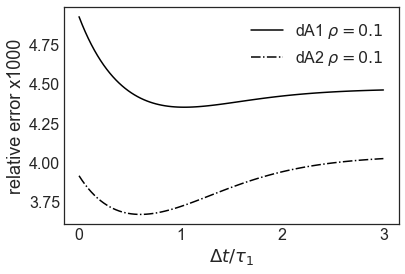

In [194]:
plt.plot(delta_t_list,np.sqrt(dA1_01)*1000,"k",label=r"dA1 $\rho=0.1$")
plt.plot(delta_t_list,np.sqrt(dA2_01)*1000,"k-.",label=r"dA2 $\rho=0.1$")
#plt.plot(delta_t_list,dD,label="dD")
#plt.plot(delta_t_list,dA1A2/A1/A2,label="dA1A2")
plt.legend()
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel("relative error x1000")
plt.savefig("dA01.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

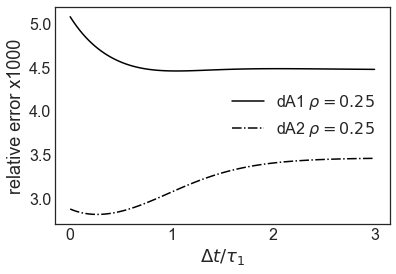

In [197]:
plt.plot(delta_t_list,np.sqrt(dA1_025)*1000,"k",label=r"dA1 $\rho=0.25$")
plt.plot(delta_t_list,np.sqrt(dA2_025)*1000,"k-.",label=r"dA2 $\rho=0.25$")
#plt.plot(delta_t_list,dD,label="dD")
#plt.plot(delta_t_list,dA1A2/A1/A2,label="dA1A2")
plt.legend()
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel("relative error x1000")
plt.savefig("dA025.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

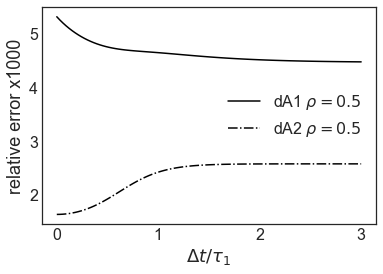

In [200]:
plt.plot(delta_t_list,np.sqrt(dA1_05)*1000,"k",label=r"dA1 $\rho=0.5$")
plt.plot(delta_t_list,np.sqrt(dA2_05)*1000,"k-.",label=r"dA2 $\rho=0.5$")
#plt.plot(delta_t_list,dD,label="dD")
#plt.plot(delta_t_list,dA1A2/A1/A2,label="dA1A2")
plt.legend()
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel("relative error x1000")
plt.savefig("dA05.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

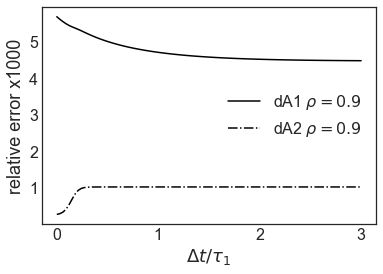

In [202]:
plt.plot(delta_t_list,np.sqrt(dA1_09)*1000,"k",label=r"dA1 $\rho=0.9$")
plt.plot(delta_t_list,np.sqrt(dA2_09)*1000,"k-.",label=r"dA2 $\rho=0.9$")
#plt.plot(delta_t_list,dD,label="dD")
#plt.plot(delta_t_list,dA1A2/A1/A2,label="dA1A2")
plt.legend()
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel("relative error x1000")
plt.savefig("dA09.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

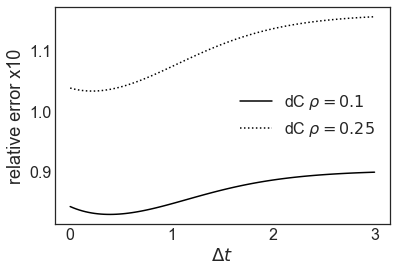

In [208]:
plt.plot(delta_t_list,np.sqrt(dC_01)*10,"k",label=r'dC $\rho = 0.1$')
plt.plot(delta_t_list,np.sqrt(dC_025)*10,"k:",label=r'dC $\rho = 0.25$')
#plt.plot(delta_t_list,np.sqrt(dC_05)*10,"k-.",label=r'$dC \rho = 0.5$')
plt.legend(loc='center right')
plt.xlabel(r"$\Delta t$")
plt.ylabel("relative error x10")
plt.savefig("dD.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

Text(0, 0.5, 'relative error dD')

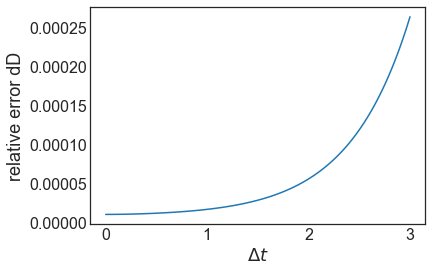

In [173]:
plt.plot(delta_t_list,dD)
plt.xlabel(r"$\Delta t$")
plt.ylabel("relative error dD")

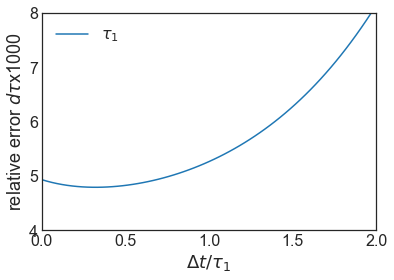

In [219]:
plt.plot(delta_t_list,dtau1_01*1000,label=r"$\tau_1$")
#plt.plot(delta_t_list,dtau1_025,label="tau1_025")
#plt.plot(delta_t_list,dtau1_05,label="tau1_025")
plt.xlim((0,2))
plt.ylim((4,8))
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel(r"relative error $d\tau$x1000")
plt.legend()

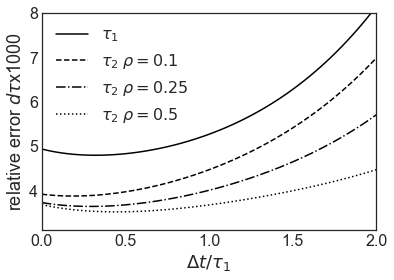

In [236]:
plt.plot(delta_t_list,dtau1_01*1000,"k",label=r"$\tau_1$")
plt.plot(delta_t_list,dtau2_01*1000,"k--",label=r"$\tau_{2}$ $\rho=0.1$")
plt.plot(delta_t_list,dtau2_025*1000,"k-.",label=r"$\tau_{2}$ $\rho=0.25$")
plt.plot(delta_t_list,dtau2_05*1000,"k:",label=r"$\tau_{2}$ $\rho=0.5$")
plt.xlim((0,2))
plt.ylim((3.1,8))
plt.xlabel(r"$\Delta t/\tau_1$")
plt.ylabel(r"relative error $d\tau$x1000")
plt.legend()
plt.savefig("dtau.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")